In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Q1**

In [2]:
from tensorflow import keras
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## **Reading Images and making training and test dataset**

In [3]:
trainImg = '/content/drive/MyDrive/MoNuSeg-Training-Data-20221107T104634Z-001/MoNuSeg-Training-Data/Tissue-Images'
trainMask = '/content/drive/MyDrive/MoNuSeg-Training-Data-20221107T104634Z-001/MoNuSeg-Training-Data/Binary-Mask'
testImg = '/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images'
testMask = '/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask'
 #Setting path to reading Images
 # epochs = 5

In [4]:
binary_img = []
tissue_img = []
test_binary_img = []
test_tissue_img = []

a = !ls '/content/drive/MyDrive/MoNuSeg-Training-Data-20221107T104634Z-001/MoNuSeg-Training-Data/Tissue-Images'
b = !ls '/content/drive/MyDrive/MoNuSeg-Training-Data-20221107T104634Z-001/MoNuSeg-Training-Data/Binary-Mask'
for i in a:
  tissue_img.append(cv.imread(trainImg + '/' + str(i.split()[0]),0))
  tissue_img.append(cv.imread(trainImg + '/' + str(i.split()[1]),0))

  binary_img.append(cv.imread(trainMask + '/' + str(i.split()[0]),0))
  binary_img.append(cv.imread(trainMask + '/' + str(i.split()[1]),0))

c = !ls '/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images'
d = !ls '/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask'
for i in c:
  test_tissue_img.append(cv.imread(testImg + '/' + str(i.split()[0]),0))
  test_tissue_img.append(cv.imread(testImg + '/' + str(i.split()[1]),0))

  test_binary_img.append(cv.imread(testMask + '/' + str(i.split()[0]),0))
  test_binary_img.append(cv.imread(testMask + '/' + str(i.split()[1]),0))


# **Data Augmentation**

In [5]:
image_size = 128
binary = []
for img in binary_img:
    n = cv.resize(img, (128, 128))
    n = n/255.0
    nhf = cv.flip(n, 0)
    nvf = cv.flip(n, 1)
    nhvf = cv.flip(n, -1)
    binary.append(n)
    binary.append(nhf)
    binary.append(nvf)
    binary.append(nhvf)

tissue = []
for img in tissue_img:
    n = cv.resize(img, (128, 128))
    n = n/255.0
    nhf = cv.flip(n, 0)
    nvf = cv.flip(n, 1)
    nhvf = cv.flip(n, -1)
    tissue.append(n)
    tissue.append(nhf)
    tissue.append(nvf)
    tissue.append(nhvf)
  
test_binary = []
for img in test_tissue_img:
    n = cv.resize(n, (128, 128))
    n = n/255.0
    test_binary.append(n)

test_tissue = []
for img in test_binary_img:
    n = cv.resize(n, (128, 128))
    n = n/255.0
    test_tissue.append(n)

In [6]:
import numpy
binary_arr = numpy.array(binary)
tissue_arr = numpy.array(tissue)
test_binary_arr = numpy.array(test_binary)
test_tissue_arr = numpy.array(test_tissue)
# converting to numpy arrays

In [7]:
binary_arr.shape

(120, 128, 128)

In [8]:
test_tissue_arr.shape

(14, 128, 128)

In [9]:
binary_arr = tf.reshape(binary_arr, (120, 128, 128, 1))
tissue_arr = tf.reshape(tissue_arr, (120, 128, 128, 1))
test_binary_arr = tf.reshape(test_binary_arr, (14, 128, 128, 1))
test_tissue_arr = tf.reshape(test_tissue_arr, (14, 128, 128, 1))
# converting to tensors

In [10]:
type(binary_arr)

tensorflow.python.framework.ops.EagerTensor

## **Displaying sample training and test images**

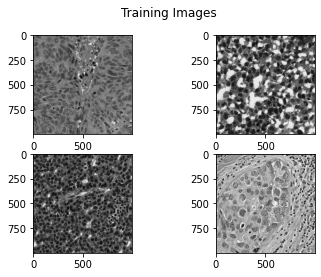

In [34]:
# displaying some training images
plt.suptitle('Training Images')
plt.subplot(2,2,1)
plt.imshow(tissue_img[0],cmap = 'gray')

plt.subplot(2,2,2)
plt.imshow(tissue_img[1],cmap = 'gray')

plt.subplot(2,2,3)
plt.imshow(tissue_img[2],cmap = 'gray')

plt.subplot(2,2,4)
plt.imshow(tissue_img[3],cmap = 'gray')

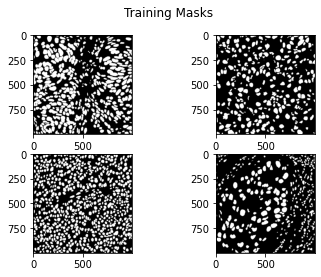

In [36]:
# displaying some training images
plt.suptitle('Training Masks')
plt.subplot(2,2,1)
plt.imshow(binary_img[0], cmap='gray')

plt.subplot(2,2,2)
plt.imshow(binary_img[1], cmap='gray')

plt.subplot(2,2,3)
plt.imshow(binary_img[2], cmap='gray')

plt.subplot(2,2,4)
plt.imshow(binary_img[3], cmap='gray')

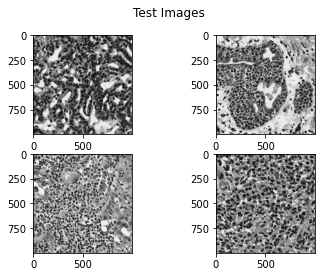

In [38]:
# displaying some test images
plt.suptitle('Test Images')
plt.subplot(2,2,1)
plt.imshow(test_tissue_img[0],cmap = 'gray')

plt.subplot(2,2,2)
plt.imshow(test_tissue_img[1],cmap = 'gray')

plt.subplot(2,2,3)
plt.imshow(test_tissue_img[2],cmap = 'gray')

plt.subplot(2,2,4)
plt.imshow(test_tissue_img[3],cmap = 'gray')

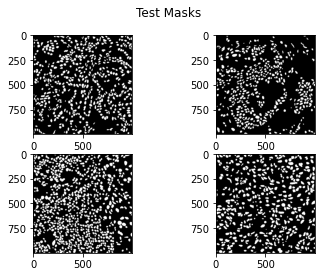

In [39]:
# displaying some training images
plt.suptitle('Test Masks')
plt.subplot(2,2,1)
plt.imshow(test_binary_img[0], cmap='gray')

plt.subplot(2,2,2)
plt.imshow(test_binary_img[1], cmap='gray')

plt.subplot(2,2,3)
plt.imshow(test_binary_img[2], cmap='gray')

plt.subplot(2,2,4)
plt.imshow(test_binary_img[3], cmap='gray')

## Q2

### **Defining blocks for Unet Network**

In [12]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)  # Adding Convolution Layer
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)  # Adding another convolution layer
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)                                                          # Adding max pooling layer
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

### **Defining Unet with 4 layers in Down network and 4 layers in Up network**

In [13]:
def UNet():
    f = [16, 32, 64, 128, 256]                                  # Filters for varioys layers of Unet
    inputs = keras.layers.Input((image_size, image_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64                    # Down network
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8 
    
    bn = bottleneck(p4, f[4])                                   # Skip layer  
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16                        # Up network
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

### **Defining dice_loss,ssim loss and tadeoff loss function**

In [14]:
import keras.backend as K
def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets*inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice
def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

def tradeOffLoss(y_true, y_pred, tradeoff=0.5) :
  a = ssim_loss(y_true, y_pred)
  b = DiceLoss(y_true, y_pred)
  return tradeoff*b + (1-tradeoff)*a;

### **Iniatializing Unet and Compiling**

In [15]:
modeldice = UNet()
modeldice.compile(optimizer="adam", loss=DiceLoss, metrics=["acc"])
modeldice.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

### **Training Model with Dice loss** 

In [16]:
modeldice.fit(tissue_arr, binary_arr, validation_data = (test_tissue_arr[:8],test_binary_arr[:8] ), batch_size=120, epochs = 20)

Epoch 1/20
1/1 [==============================] - 13s 13s/step - loss: 0.6573 - acc: 0.7055 - val_loss: 0.9995 - val_acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 321ms/step - loss: 0.6535 - acc: 0.7023 - val_loss: 0.9995 - val_acc: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 342ms/step - loss: 0.6514 - acc: 0.2550 - val_loss: 0.9995 - val_acc: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 396ms/step - loss: 0.6473 - acc: 0.2396 - val_loss: 0.9995 - val_acc: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 340ms/step - loss: 0.6314 - acc: 0.2356 - val_loss: 0.9995 - val_acc: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 333ms/step - loss: 0.5904 - acc: 0.2355 - val_loss: 0.9995 - val_acc: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 351ms/step - loss: 0.5818 - acc: 0.2355 - val_loss: 0.9995 - val_acc: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 329ms/step

1/1 [==============================] - 1s 876ms/step


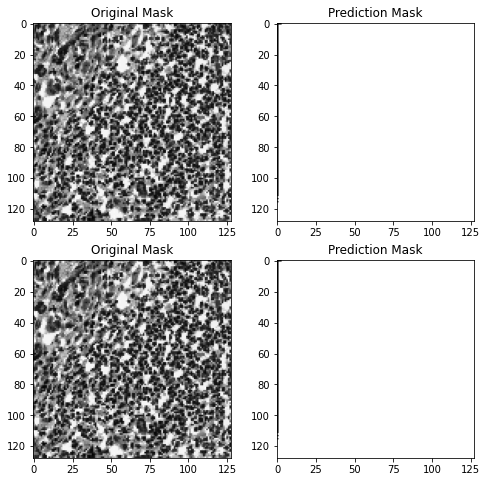

In [17]:
pred = modeldice.predict(test_tissue_arr)
pred = np.reshape(pred, (pred.shape[0], 128, 128))
orig = np.array(test_binary_arr)
orig = np.reshape(orig, (orig.shape[0], 128, 128))
fig = plt.figure(figsize = [8, 8])
plt.subplot(221)
plt.imshow(orig[0], cmap="gray")
plt.title("Original Mask")
plt.subplot(222)
plt.title("Prediction Mask")
plt.imshow(pred[0], cmap="gray")
plt.subplot(223)
plt.imshow(orig[3], cmap="gray")
plt.title("Original Mask")
plt.subplot(224)
plt.title("Prediction Mask")
plt.imshow(pred[3], cmap="gray")

In [18]:
DiceLoss(tf.reshape(pred[0].astype("float"), (1, 128, 128, 1)), tf.reshape(orig[0].astype("float"), (1, 128, 128, 1)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9962489996377574>

As can be seen, the Dice loss does not give a good result, on training the neural net. Even on increasing the randomness in the initialization in the weights, the output maps do not resemble the labels(ground truths) to a good extent. The reason may be that, since the working space is limited(all pixels have to be in 0 to 1, as has to be the loss), and the architecture is vast, the weights tend to correlate a lot, resulting in redundancy in training. This can be validates by sligtly reducing the randomness in the weights and observing the output.

Observation : --> For very less randomness, the output maps are all 1s --> For some range of intermediate values in the initializations, all the pixel intensities remain the same(I got one reault in which all pixel intensities were 0.5482)

Owing to these drawbacks, I now try to train the model using standard mse loss, and, as will be clear, this gives much better results

### **Model training using "Mean Square Error"**

In [19]:
model = UNet()
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_19[0][0]']              
                                )                                                           

### **Training Unet**

In [20]:
model.fit(tissue_arr, binary_arr, validation_data = (test_tissue_arr[:8],test_binary_arr[:8] ), batch_size=120, epochs = 20)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.2306 - val_loss: 0.2473
Epoch 2/20
1/1 [==============================] - 0s 371ms/step - loss: 0.2196 - val_loss: 0.2403
Epoch 3/20
1/1 [==============================] - 0s 369ms/step - loss: 0.1992 - val_loss: 0.2018
Epoch 4/20
1/1 [==============================] - 0s 349ms/step - loss: 0.2096 - val_loss: 0.2271
Epoch 5/20
1/1 [==============================] - 0s 310ms/step - loss: 0.1830 - val_loss: 0.2320
Epoch 6/20
1/1 [==============================] - 0s 353ms/step - loss: 0.1827 - val_loss: 0.2308
Epoch 7/20
1/1 [==============================] - 0s 318ms/step - loss: 0.1812 - val_loss: 0.2271
Epoch 8/20
1/1 [==============================] - 0s 325ms/step - loss: 0.1804 - val_loss: 0.2252
Epoch 9/20
1/1 [==============================] - 0s 365ms/step - loss: 0.1806 - val_loss: 0.2274
Epoch 10/20
1/1 [==============================] - 0s 357ms/step - loss: 0.1796 - val_loss: 0.2307
Epoch 11/20
1/1 [=====

## **Q4**

### **Prediction of Unet on Test data**

4/4 [==============================] - 1s 184ms/step


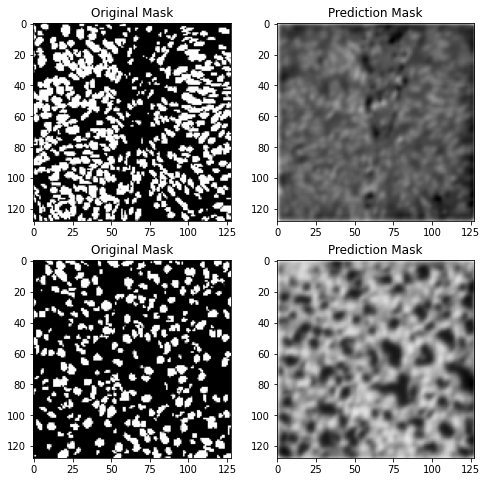

In [21]:
pred = model.predict(tissue_arr)
pred = np.reshape(pred, (pred.shape[0], 128, 128))
orig = np.array(binary_arr)
orig = np.reshape(orig, (orig.shape[0], 128, 128))
fig = plt.figure(figsize = [8, 8])
plt.subplot(221)
plt.imshow(orig[0], cmap="gray")
plt.title("Original Mask")
plt.subplot(222)
plt.title("Prediction Mask")
plt.imshow(pred[0], cmap="gray")
plt.subplot(223)
plt.imshow(orig[6], cmap="gray")
plt.title("Original Mask")
plt.subplot(224)
plt.title("Prediction Mask")
plt.imshow(pred[6], cmap="gray")

As we can see we get much better result with "MSE" Loss as compared to "Dice Loss

## **Q5 (a)**

In [22]:
def UNet1():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64                                    
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    # c4, p4 = down_block(p3, f[3]) #16->8                                      #Removing 1 layer from both Up and Down Network
    
    bn = bottleneck(p3, f[3])
    
    # u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(bn, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [23]:
model1 = UNet1()
model1.compile(optimizer="adam", loss="mse")
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_38[0][0]']              
                                )                                                           

In [24]:
model1.fit(tissue_arr, binary_arr, validation_data = (test_tissue_arr[:8],test_binary_arr[:8] ), batch_size=120, epochs = 20)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.2422 - val_loss: 0.2490
Epoch 2/20
1/1 [==============================] - 0s 280ms/step - loss: 0.2405 - val_loss: 0.2477
Epoch 3/20
1/1 [==============================] - 0s 285ms/step - loss: 0.2393 - val_loss: 0.2458
Epoch 4/20
1/1 [==============================] - 0s 286ms/step - loss: 0.2357 - val_loss: 0.2417
Epoch 5/20
1/1 [==============================] - 0s 282ms/step - loss: 0.2272 - val_loss: 0.2295
Epoch 6/20
1/1 [==============================] - 0s 288ms/step - loss: 0.2075 - val_loss: 0.1932
Epoch 7/20
1/1 [==============================] - 0s 290ms/step - loss: 0.1907 - val_loss: 0.1680
Epoch 8/20
1/1 [==============================] - 0s 283ms/step - loss: 0.2039 - val_loss: 0.1915
Epoch 9/20
1/1 [==============================] - 0s 280ms/step - loss: 0.1898 - val_loss: 0.2107
Epoch 10/20
1/1 [==============================] - 0s 287ms/step - loss: 0.1912 - val_loss: 0.2146
Epoch 11/20
1/1 [=====

4/4 [==============================] - 0s 32ms/step


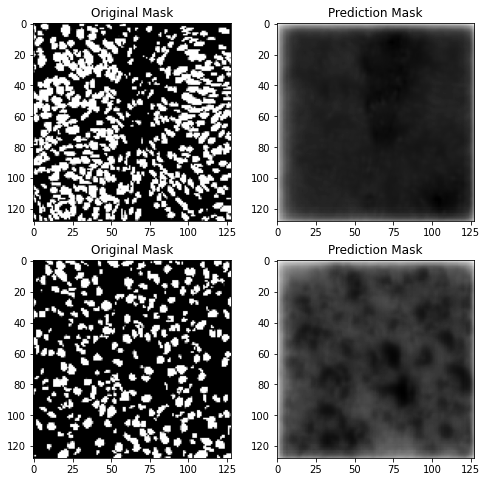

In [25]:
pred = model1.predict(tissue_arr)
pred = np.reshape(pred, (pred.shape[0], 128, 128))
orig = np.array(binary_arr)
orig = np.reshape(orig, (orig.shape[0], 128, 128))
fig = plt.figure(figsize = [8, 8])
plt.subplot(221)
plt.imshow(orig[0], cmap="gray")
plt.title("Original Mask")
plt.subplot(222)
plt.title("Prediction Mask")
plt.imshow(pred[0], cmap="gray")
plt.subplot(223)
plt.imshow(orig[6], cmap="gray")
plt.title("Original Mask")
plt.subplot(224)
plt.title("Prediction Mask")
plt.imshow(pred[6], cmap="gray")

### **Defining Unet with 2 blocks in Down network and 2 blocks in Up network**

In [26]:
def UNet2():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    # c3, p3 = down_block(p2, f[2]) #32 -> 16
    # c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p2, f[3])
    
    # u1 = up_block(bn, c4, f[3]) #8 -> 16
    # u2 = up_block(bn, c3, f[2]) #16 -> 32
    u3 = up_block(bn, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [27]:
model2 = UNet2()
model2.compile(optimizer="adam", loss="mse")
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_53 (Conv2D)             (None, 128, 128, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_53[0][0]']              
                                )                                                           

In [28]:
model2.fit(tissue_arr, binary_arr, validation_data = (test_tissue_arr[:8],test_binary_arr[:8] ), batch_size=120, epochs = 20)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.2388 - val_loss: 0.2467
Epoch 2/20
1/1 [==============================] - 0s 286ms/step - loss: 0.2355 - val_loss: 0.2415
Epoch 3/20
1/1 [==============================] - 0s 299ms/step - loss: 0.2285 - val_loss: 0.2314
Epoch 4/20
1/1 [==============================] - 0s 285ms/step - loss: 0.2150 - val_loss: 0.2104
Epoch 5/20
1/1 [==============================] - 0s 288ms/step - loss: 0.1942 - val_loss: 0.1643
Epoch 6/20
1/1 [==============================] - 0s 296ms/step - loss: 0.1918 - val_loss: 0.1533
Epoch 7/20
1/1 [==============================] - 0s 282ms/step - loss: 0.1974 - val_loss: 0.1679
Epoch 8/20
1/1 [==============================] - 0s 282ms/step - loss: 0.1893 - val_loss: 0.1850
Epoch 9/20
1/1 [==============================] - 0s 289ms/step - loss: 0.1848 - val_loss: 0.1950
Epoch 10/20
1/1 [==============================] - 0s 287ms/step - loss: 0.1864 - val_loss: 0.1965
Epoch 11/20
1/1 [=====

4/4 [==============================] - 1s 81ms/step


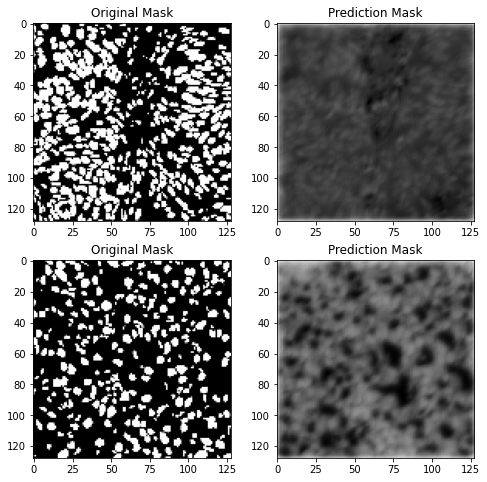

In [29]:
pred = model2.predict(tissue_arr)
pred = np.reshape(pred, (pred.shape[0], 128, 128))
orig = np.array(binary_arr)
orig = np.reshape(orig, (orig.shape[0], 128, 128))
fig = plt.figure(figsize = [8, 8])
plt.subplot(221)
plt.imshow(orig[0], cmap="gray")
plt.title("Original Mask")
plt.subplot(222)
plt.title("Prediction Mask")
plt.imshow(pred[0], cmap="gray")
plt.subplot(223)
plt.imshow(orig[6], cmap="gray")
plt.title("Original Mask")
plt.subplot(224)
plt.title("Prediction Mask")
plt.imshow(pred[6], cmap="gray")

From the above results it can be observed that the loss decrease as the number of blocks decreases from 4 to 3 and then increases when the blocks were set to 2 in both downsampling and upsampling

## **Q5 (b)**

### **Defining Unet with 4 layers in Down network and 4 layers in Up network and with changed filters**

In [30]:
def UNet3():
    f = [20, 40, 50, 60, 100]
    inputs = keras.layers.Input((image_size, image_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0])
    c2, p2 = down_block(p1, f[1])
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3])
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1]) 
    u4 = up_block(u3, c1, f[0])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [31]:
model3 = UNet3()
model3.compile(optimizer="adam", loss="mse")
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_64 (Conv2D)             (None, 128, 128, 20  200         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 128, 128, 20  3620        ['conv2d_64[0][0]']              
                                )                                                           

In [32]:
model3.fit(tissue_arr, binary_arr, validation_data = (test_tissue_arr[:8],test_binary_arr[:8] ), batch_size=120, epochs = 20)

Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 0.2409 - val_loss: 0.2490
Epoch 2/20
1/1 [==============================] - 0s 336ms/step - loss: 0.2391 - val_loss: 0.2479
Epoch 3/20
1/1 [==============================] - 0s 342ms/step - loss: 0.2345 - val_loss: 0.2448
Epoch 4/20
1/1 [==============================] - 0s 337ms/step - loss: 0.2265 - val_loss: 0.2365
Epoch 5/20
1/1 [==============================] - 0s 335ms/step - loss: 0.2080 - val_loss: 0.2100
Epoch 6/20
1/1 [==============================] - 0s 330ms/step - loss: 0.1880 - val_loss: 0.1995
Epoch 7/20
1/1 [==============================] - 0s 329ms/step - loss: 0.1930 - val_loss: 0.2165
Epoch 8/20
1/1 [==============================] - 0s 341ms/step - loss: 0.1852 - val_loss: 0.2221
Epoch 9/20
1/1 [==============================] - 0s 338ms/step - loss: 0.1865 - val_loss: 0.2197
Epoch 10/20
1/1 [==============================] - 0s 337ms/step - loss: 0.1844 - val_loss: 0.2130
Epoch 11/20
1/1 [=====

4/4 [==============================] - 0s 21ms/step


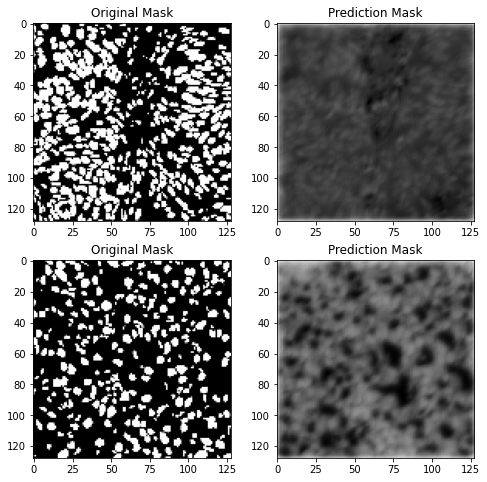

In [33]:
pred = model2.predict(tissue_arr)
pred = np.reshape(pred, (pred.shape[0], 128, 128))
orig = np.array(binary_arr)
orig = np.reshape(orig, (orig.shape[0], 128, 128))
fig = plt.figure(figsize = [8, 8])
plt.subplot(221)
plt.imshow(orig[0], cmap="gray")
plt.title("Original Mask")
plt.subplot(222)
plt.title("Prediction Mask")
plt.imshow(pred[0], cmap="gray")
plt.subplot(223)
plt.imshow(orig[6], cmap="gray")
plt.title("Original Mask")
plt.subplot(224)
plt.title("Prediction Mask")
plt.imshow(pred[6], cmap="gray")